In [1]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as sm

In [2]:
water = pd.read_csv('drinking_water_potability.csv')
water.head()
water = water.dropna()
water.head()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
3,8.316766,214.373394,22018.41744,8.059332,356.886136,363.266516,18.436525,100.341674,4.628771,0
4,9.092223,181.101509,17978.98634,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0
5,5.584087,188.313324,28748.68774,7.544869,326.678363,280.467916,8.399735,54.917862,2.559708,0
6,10.223862,248.071735,28749.71654,7.513408,393.663395,283.651634,13.789695,84.603556,2.672989,0
7,8.635849,203.361523,13672.09176,4.563009,303.309771,474.607645,12.363817,62.798309,4.401425,0


In [3]:
np.random.seed(2)
# 80% to be training
train = water.sample(round(water.shape[0]*.8))
# drop the train data from the test df
test = water.drop(train.index)

In [62]:
def confusion_matrix_test(data,actual_values,model,cutoff=0.48):
#Predict the values using the Logit model
    pred_values = model.predict(data)
# Specify the bins
    bins=np.array([0,cutoff,1])
#Confusion matrix
    cm = np.histogram2d(actual_values, pred_values, bins=bins)[0]
    cm_df = pd.DataFrame(cm)
    cm_df.columns = ['Predicted 0','Predicted 1']
    cm_df = cm_df.rename(index={0: 'Actual 0',1:'Actual 1'})
    accuracy = (cm[0,0]+cm[1,1])/cm.sum()
    sns.heatmap(cm_df, annot=True, cmap='Blues', fmt='g')
    plt.ylabel("Actual Values")
    plt.xlabel("Predicted Values")
    print("Classification accuracy = {:.1%}".format(accuracy))
    return cm

def accuracytest(data,actual_values,model,cutoff=0.5):
#Predict the values using the Logit model
    pred_values = model.predict(data)
# Specify the bins
    bins=np.array([0,cutoff,1])
#Confusion matrix
    cm = np.histogram2d(actual_values, pred_values, bins=bins)[0]
    cm_df = pd.DataFrame(cm)
    cm_df.columns = ['Predicted 0','Predicted 1']
    cm_df = cm_df.rename(index={0: 'Actual 0',1:'Actual 1'})
    accuracy = (cm[0,0]+cm[1,1])/cm.sum()
    #sns.heatmap(cm_df, annot=True, cmap='Blues', fmt='g')
    #plt.ylabel("Actual Values")
    #plt.xlabel("Predicted Values")
    #print("Classification accuracy = {:.1%}".format(accuracy))
    return accuracy

Optimization terminated successfully.
         Current function value: 0.671184
         Iterations 4
Classification accuracy = 60.4%


array([1191.,    9.])

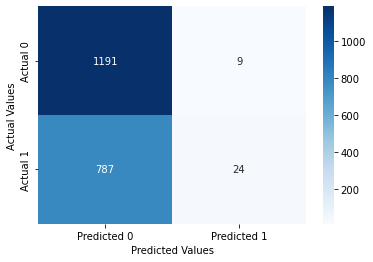

In [5]:
logit_model = sm.logit(formula = 'Potability~Hardness*Solids+Chloramines*Sulfate+\
                Organic_carbon*Sulfate+Conductivity*Hardness+Chloramines*Organic_carbon', data = water).fit() #Developing logistic regression model
logit_model.summary()
accuracy,cm = confusion_matrix_test(water,water.Potability,logit_model,.5)
accuracy

In [6]:
#Function to select the best model amongst all models with 'k' predictors
def getBest_model(k):
    results = []
    for combo in itertools.combinations(X.columns, k):
        results.append(processSubset((list(combo))))

    # Wrap everything up in a dataframe
    models = pd.DataFrame(results)

    # Choose the model with the highest RSS
    best_model = models.loc[models['Accuracy'].argmax()]
    return best_model

In [7]:
def best_sub_plots():
    plt.figure(figsize=(20,10))
    plt.rcParams.update({'font.size': 18, 'lines.markersize': 10})

    # Set up a 2x2 grid so we can look at 4 plots at once
    plt.subplot(2, 2, 1)

    # We will now plot a red dot to indicate the model with the largest adjusted R^2 statistic.
    # The argmax() function can be used to identify the location of the maximum point of a vector
    accuracy = models_best.apply(lambda row: accuracytest(test,test.Potability,row[1],cutoff=0.5), axis=1)
    plt.plot(models_best["Accuracy"])
    plt.plot(1+accuracy.argmax(), accuracy.max(), "or")
    plt.xlabel('# Predictors')
    plt.ylabel('Accuracy')

In [8]:
def processSubset(predictor_subset):
    # Fit model on feature_set and calculate R-squared
    model = sm.ols('Potability~' + '+'.join(predictor_subset),data = train).fit()
    accuracy = accuracytest(test,test.Potability,model,cutoff=0.5)
    return {"model":model, "Accuracy":accuracy}

In [9]:
train.head()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
773,6.848330,195.451482,15908.64209,6.241349,319.264722,404.204859,18.937338,75.392795,3.732202,1
1200,8.016279,211.029304,14034.48580,9.797000,389.338796,491.079082,14.512991,35.565966,4.308223,1
1086,7.845880,193.785000,13769.86024,9.007161,343.620823,510.305603,13.767802,99.175595,3.667154,1
3057,7.985406,200.134697,17583.08033,6.771729,296.569823,377.584203,10.289288,66.890747,4.752452,0
2965,9.459931,222.894659,14450.17575,6.790914,293.746321,433.145005,9.069161,67.906813,3.322890,0


In [10]:
#RUN ONCE otherwise X will expand like crazy
from sklearn.metrics import r2_score
import itertools
X = train.loc[:, train.columns!='Potability']
train2 = train.copy()
test2 = test.copy()
#Creating a dataframe with all the predictors
#Since 'X' will change when we include interactions, we need a backup containing all individual predictors
X_backup = train.loc[:, train.columns!='Potability']
#Including 2-factor interactions of predictors in train and 'X'. Note that we need train to develop the model, and X to 
#find 'k' variable subsets from amongst all the predictors under consideration
for combo in itertools.combinations(X_backup.columns, 2):    
    train['_'.join(combo)] = train[combo[0]]*train[combo[1]]
    test['_'.join(combo)] = test[combo[0]]*test[combo[1]]
    X.loc[:,'_'.join(combo)] = train.loc[:,'_'.join(combo)]

/var/folders/cn/xv0m3s5s38sfrgjbj_47jlc40000gn/T/ipykernel_13132/2046910641.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.loc[:,'_'.join(combo)] = train.loc[:,'_'.join(combo)]
/var/folders/cn/xv0m3s5s38sfrgjbj_47jlc40000gn/T/ipykernel_13132/2046910641.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.loc[:,'_'.join(combo)] = train.loc[:,'_'.join(combo)]
/var/folders/cn/xv0m3s5s38sfrgjbj_47jlc40000gn/T/ipykernel_13132/2046910641.py:15: SettingWithCopyWarning: 
A value is trying to be set on a c

/var/folders/cn/xv0m3s5s38sfrgjbj_47jlc40000gn/T/ipykernel_13132/2046910641.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.loc[:,'_'.join(combo)] = train.loc[:,'_'.join(combo)]
/var/folders/cn/xv0m3s5s38sfrgjbj_47jlc40000gn/T/ipykernel_13132/2046910641.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.loc[:,'_'.join(combo)] = train.loc[:,'_'.join(combo)]
/var/folders/cn/xv0m3s5s38sfrgjbj_47jlc40000gn/T/ipykernel_13132/2046910641.py:15: SettingWithCopyWarning: 
A value is trying to be set on a c

In [11]:
#Function to select the best model amongst the best models for 'k' predictors, where k = 1,2,3,..
'''models_best = pd.DataFrame(columns=["Accuracy", "model"])

for i in range(1,1+X.shape[1]):
    models_best.loc[i] = getBest_model(i)
models_best'''

KeyboardInterrupt: 

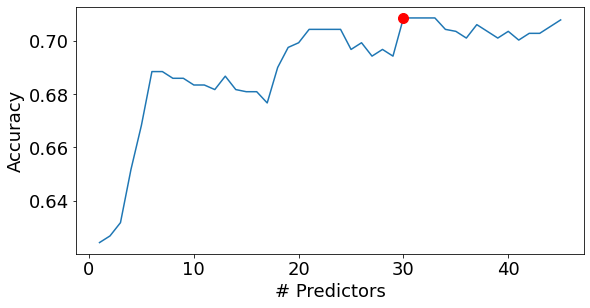

In [12]:
#Function to find the best predictor out of p-k predictors and add it to the model containing the k predictors
def forward(predictors):

    # Pull out predictors we still need to process
    remaining_predictors = [p for p in X.columns if p not in predictors]
    results = []
    
    for p in remaining_predictors:
        results.append(processSubset(predictors+[p]))
    
    # Wrap everything up in a nice dataframe
    models = pd.DataFrame(results)
    
    # Choose the model with the highest RSS
    best_model = models.loc[models['Accuracy'].argmax()]

    # Return the best model, along with some other useful information about the model
    return best_model

def forward_selection():
    models_best = pd.DataFrame(columns=["Accuracy", "model"])

    predictors = []

    for i in range(1,len(X.columns)+1):    
        models_best.loc[i] = forward(predictors)
        predictors = list(models_best.loc[i]["model"].params.index[1:])
    return models_best

models_best = forward_selection()
best_sub_plots()


In [13]:
models_best.Accuracy.sort_values(ascending=False)

33    0.708543
32    0.708543
31    0.708543
30    0.708543
45    0.707809
37     0.70603
44     0.70529
21    0.704261
34    0.704261
24    0.704261
22    0.704261
23    0.704261
35    0.703518
40    0.703518
38    0.703518
43    0.702771
42    0.702771
39    0.701005
36    0.701005
41    0.700252
20    0.699248
26    0.699248
19      0.6975
28    0.696742
25    0.696742
27    0.694236
29    0.694236
18        0.69
7     0.688442
6     0.688442
13    0.686717
8      0.68593
9      0.68593
10    0.683417
11    0.683417
14    0.681704
12    0.681704
16    0.680905
15    0.680905
17    0.676692
5     0.668342
4     0.651741
3     0.631841
2     0.626866
1     0.624378
Name: Accuracy, dtype: object

In [14]:
models_best.loc[33,'model'].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Potability   R-squared:                       0.088
Model:                            OLS   Adj. R-squared:                  0.069
Method:                 Least Squares   F-statistic:                     4.627
Date:                Fri, 03 Mar 2023   Prob (F-statistic):           2.32e-16
Time:                        15:08:39   Log-Likelihood:                -1066.6
No. Observations:                1609   AIC:                             2201.
Df Residuals:                    1575   BIC:                             2384.
Df Model:                          33                                         
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept                          1.3542      1.020      1.327      0.185      -0.647       3.355
Solids_Conductivity            -1.126e-08   1.64e-08     -0.686      0.493   -4.35e-08    2.09e-08
ph_Chloramines                     0.0270      0.005      5.937      0.000       0.018       0.036
Chloramines                       -0.1967      0.083     -2.379      0.017      -0.359      -0.035
ph_Sulfate                        -0.0009      0.000     -5.675      0.000      -0.001      -0.001
Chloramines_Sulfate                0.0003      0.000      2.176      0.030    2.78e-05       0.001
Organic_carbon_Trihalomethanes    8.6e-06      0.000      0.037      0.971      -0.000       0.000
ph_Hardness                       -0.0002      0.000     -1.115      0.265      -0.001       0.000
Hardness                           0.0020      0.003      0.589      0.556      -0.005       0.009
ph_Organic_carbon              -5.263e-06      0.002     -0.002      0.998      -0.005       0.005
Solids_Chloramines             -1.531e-06   8.79e-07     -1.740      0.082   -3.26e-06    1.94e-07
Solids_Sulfate                 -8.399e-08   2.81e-08     -2.994      0.003   -1.39e-07    -2.9e-08
Hardness_Trihalomethanes        9.896e-07   2.47e-05      0.040      0.968   -4.74e-05    4.94e-05
Trihalomethanes                   -0.0036      0.009     -0.413      0.680      -0.021       0.014
Turbidity                         -0.0590      0.134     -0.440      0.660      -0.322       0.204
Hardness_Turbidity                 0.0003      0.000      0.695      0.487      -0.001       0.001
Sulfate_Conductivity             4.41e-06   2.56e-06      1.726      0.085   -6.01e-07    9.42e-06
ph_Solids                       3.288e-06   7.82e-07      4.206      0.000    1.75e-06    4.82e-06
Solids_Trihalomethanes          9.774e-08   9.12e-08      1.072      0.284   -8.11e-08    2.77e-07
Chloramines_Trihalomethanes        0.0002      0.000      0.377      0.706      -0.001       0.001
Hardness_Solids                -5.408e-08   4.03e-08     -1.342      0.180   -1.33e-07    2.49e-08
Organic_carbon                    -0.0998      0.048     -2.064      0.039      -0.195      -0.005
Solids_Turbidity               -3.868e-07   1.82e-06     -0.213      0.831   -3.95e-06    3.17e-06
ph_Trihalomethanes              8.049e-06      0.001      0.016      0.987      -0.001       0.001
ph_Turbidity                       0.0035      0.010      0.347      0.728      -0.016       0.023
Organic_carbon_Turbidity          -0.0012      0.004     -0.262      0.793      -0.010       0.008
Solids_Organic_carbon           3.515e-07   4.13e-07      0.851      0.395   -4.59e-07    1.16e-06
ph                                 0.0703      0.106      0.662      0.508      -0.138       0.279
Solids        

Classification accuracy = 70.9%


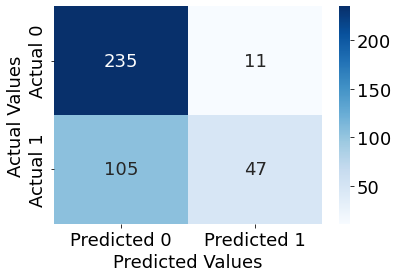

In [15]:
cm = confusion_matrix_test(test,test.Potability,models_best.loc[33,'model'],cutoff=0.5)

In [16]:
cm[1,1]/(cm[1,1]+cm[1,0])

0.3092105263157895

Optimization terminated successfully.
         Current function value: 0.674403
         Iterations 4
Classification accuracy = 62.4%


array([[249.,   1.],
       [150.,   2.]])

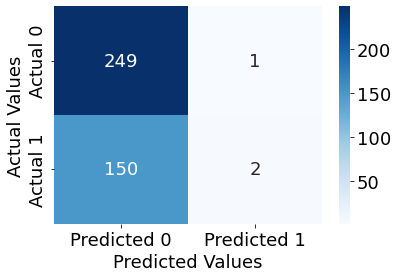

In [24]:
#model with all 
model_all = sm.logit("Potability~" + "+".join(X_backup.columns), data = train2).fit()
confusion_matrix_test(test, test.Potability, model_all)

Optimization terminated successfully.
         Current function value: 0.671369
         Iterations 5
Classification accuracy = 63.2%
Optimization terminated successfully.
         Current function value: 0.669043
         Iterations 5
Classification accuracy = 60.0%
Optimization terminated successfully.
         Current function value: 0.674215
         Iterations 4
Classification accuracy = 61.9%
Optimization terminated successfully.
         Current function value: 0.669344
         Iterations 4
Classification accuracy = 62.7%
Optimization terminated successfully.
         Current function value: 0.662274
         Iterations 5
Classification accuracy = 64.9%
Optimization terminated successfully.
         Current function value: 0.673812
         Iterations 4
Classification accuracy = 61.7%
Optimization terminated successfully.
         Current function value: 0.674089
         Iterations 4
Classification accuracy = 62.2%
Optimization terminated successfully.
         Current functio

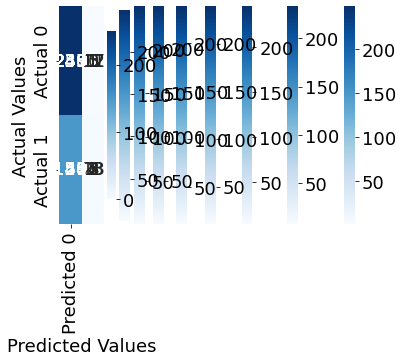

In [27]:
for i in model_all.params.index[1:]:
    model = sm.logit("Potability~" + "+".join(X_backup.columns) + "+I(" + i + "**2)", data = train2).fit()
    confusion_matrix_test(test, test.Potability, model)

In [41]:
best_in_model = models_best.loc[33,'model']
best_in_model.params.index[1:]

Index(['Solids_Conductivity', 'ph_Chloramines', 'Chloramines', 'ph_Sulfate',
       'Chloramines_Sulfate', 'Organic_carbon_Trihalomethanes', 'ph_Hardness',
       'Hardness', 'ph_Organic_carbon', 'Solids_Chloramines', 'Solids_Sulfate',
       'Hardness_Trihalomethanes', 'Trihalomethanes', 'Turbidity',
       'Hardness_Turbidity', 'Sulfate_Conductivity', 'ph_Solids',
       'Solids_Trihalomethanes', 'Chloramines_Trihalomethanes',
       'Hardness_Solids', 'Organic_carbon', 'Solids_Turbidity',
       'ph_Trihalomethanes', 'ph_Turbidity', 'Organic_carbon_Turbidity',
       'Solids_Organic_carbon', 'ph', 'Solids', 'Sulfate_Organic_carbon',
       'Chloramines_Conductivity', 'Hardness_Conductivity',
       'Conductivity_Organic_carbon', 'Conductivity_Trihalomethanes'],
      dtype='object')

Optimization terminated successfully.
         Current function value: 0.617715
         Iterations 6
Classification accuracy = 67.2%
Optimization terminated successfully.
         Current function value: 0.619973
         Iterations 6
Classification accuracy = 67.7%
Optimization terminated successfully.
         Current function value: 0.623241
         Iterations 6
Classification accuracy = 68.7%
Optimization terminated successfully.
         Current function value: 0.618928
         Iterations 6
Classification accuracy = 70.1%
Optimization terminated successfully.
         Current function value: 0.596710
         Iterations 6
Classification accuracy = 71.4%
Optimization terminated successfully.
         Current function value: 0.617484
         Iterations 6
Classification accuracy = 68.4%
Optimization terminated successfully.
         Current function value: 0.622295
         Iterations 6
Classification accuracy = 69.7%
Optimization terminated successfully.
         Current functio

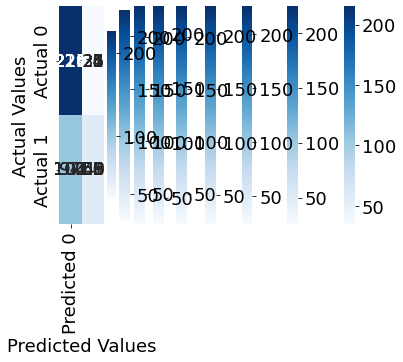

In [49]:
for i in model_all.params.index[1:]:
    model = sm.logit("Potability~" + "+".join(best_in_model.params.index[1:]) + "+I(" + i + "**2)+I(" + i + "**3)", data = train).fit()
    confusion_matrix_test(test, test.Potability, model)

Optimization terminated successfully.
         Current function value: 0.596710
         Iterations 6
Classification accuracy = 71.9%


array([[222.,  28.],
       [ 85.,  67.]])

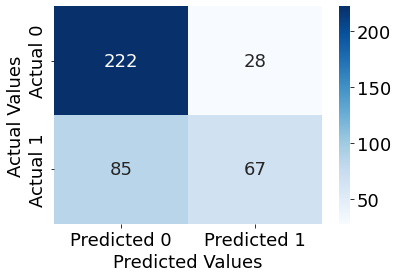

In [63]:
model_best = sm.logit("Potability~" + "+".join(best_in_model.params.index[1:]) + "+I(Sulfate**2)+I(Sulfate**3)", data = train).fit()
confusion_matrix_test(test, test.Potability, model_best)